# Lab Instructions

Create 3 visualizations from text data of your choice.  Each visualization should have at least 1 - 2 sentences explaining both the figure and the interpretation.
You may use any LLM and produce whatever visuals you think best illustrate your data.  

In [13]:
import pandas as pd

df = pd.read_csv('TNG.csv', encoding="latin1")

df.head()


,Unnamed: 0,episode,productionnumber,setnames,characters,act,scenenumber,scenedetails,partnumber,type,who,text,speechdescription,Released,Episode,imdbRating,imdbID,Season
0,1,encounter at farpoint,NaN,NaN,NaN,TEASER,1,NaN,1,description,NaN,The U.S.S. Enterprise NCC 1701-D traveling at...,False,1987-09-26,1.0,6.9,tt0094030,1.0
1,2,encounter at farpoint,NaN,NaN,NaN,TEASER,1,NaN,2,speech,PICARD V.O.,"Captain's log, stardate 42353.7. Our destinat...",False,1987-09-26,1.0,6.9,tt0094030,1.0
2,3,encounter at farpoint,NaN,NaN,NaN,TEASER,2,NaN,3,description,NaN,on the gigantic new Enterprise NCC 1701-D.,False,1987-09-26,1.0,6.9,tt0094030,1.0
3,4,encounter at farpoint,NaN,NaN,NaN,TEASER,2,NaN,4,speech,PICARD V.O.,"My orders are to examine Farpoint, a starbase...",False,1987-09-26,1.0,6.9,tt0094030,1.0
4,5,encounter at farpoint,NaN,NaN,NaN,TEASER,3,NaN,5,description,NaN,"Huge, with a giant wall diagram showing the i...",False,1987-09-26,1.0,6.9,tt0094030,1.0


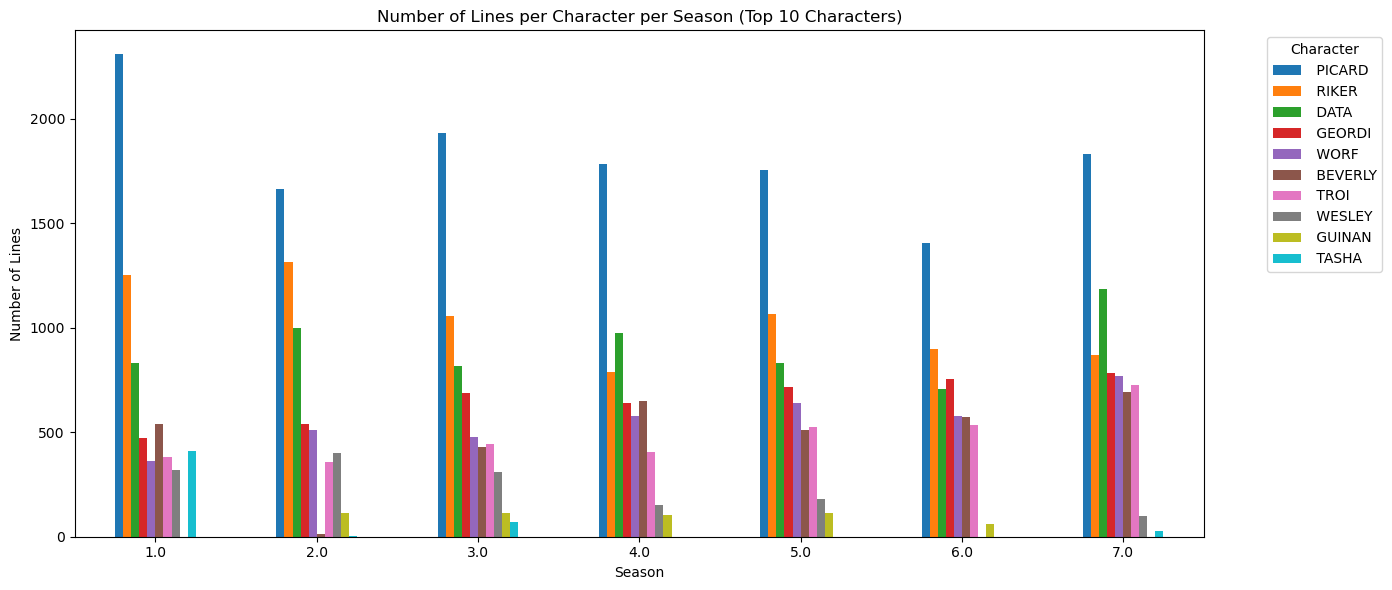

In [17]:
import matplotlib.pyplot as plt

# Filter out rows with missing speaker
df_speech = df.dropna(subset=['who'])

# Count number of lines per character per season
lines_per_season = df_speech.groupby(['Season', 'who']).size().unstack(fill_value=0)

# Select top characters overall for clarity
top_chars = df_speech['who'].value_counts().head(10).index
lines_per_season = lines_per_season[top_chars]

# Plot
lines_per_season.plot(kind='bar', figsize=(14, 6))
plt.title("Number of Lines per Character per Season (Top 10 Characters)")
plt.xlabel("Season")
plt.ylabel("Number of Lines")
plt.xticks(rotation=0)
plt.legend(title="Character", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualization 1
This is a simple bar graph showing who speaks the most lines in each season of Star Trek: The Next Generation. This gives some insight into the most important characters of each season and how that changed based on story arc of the season. In particular, this shows the growing popularity of the "secondary" bridge crew members and the declining popularity of Commander Riker.

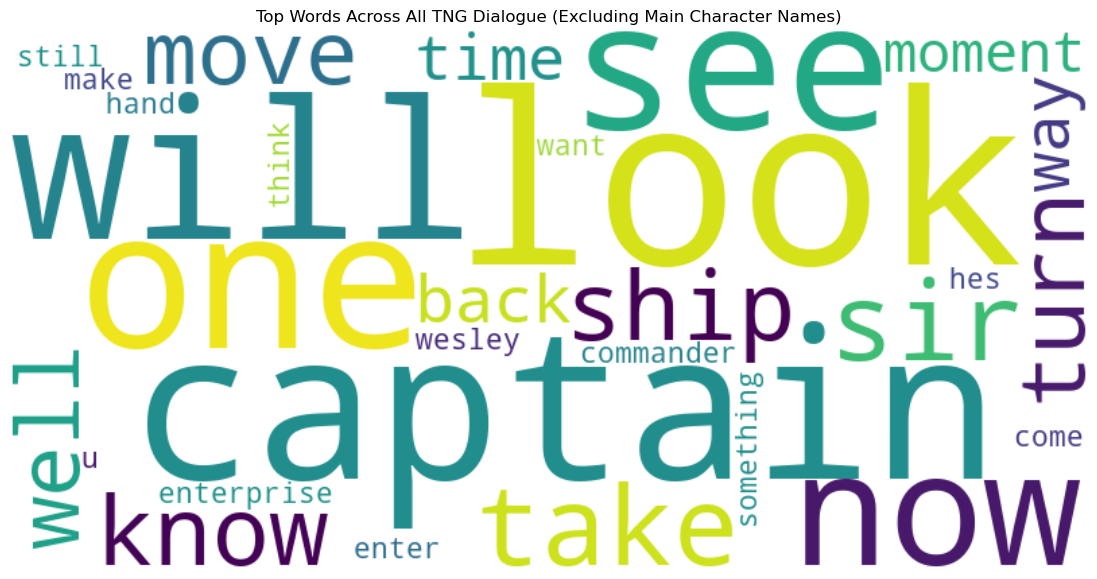

In [33]:
from wordcloud import WordCloud, STOPWORDS
import re

# Combine all dialogue text
all_text = ' '.join(df['text'].dropna().astype(str))

# Lowercase and remove punctuation
all_text_clean = re.sub(r'[^\w\s]', '', all_text).lower()

# Add main character names to stopwords
main_characters = ['Picard', 'Riker', 'Worf', 'Data', 'Geordi', 'Troi', 'Beverly', 'Crusher', 'Dr Crusher']
custom_stopwords = STOPWORDS.union(name.lower() for name in main_characters)

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=custom_stopwords,
    max_words=30
).generate(all_text_clean)

# Plot
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top Words Across All TNG Dialogue (Excluding Main Character Names)")
plt.show()

# Visualization 2
This is a simple word cloud of words used thoughout the entire series, minus the main character/bridge crew names. I find it a little harder to see what the usefulness of this visualization is because of the cluttered style. However, some things that stand out: 1) "Wesley" is in the top 30 words of the entire series, though he only appeard in 68 of the 178 episodes. 2) "Captain" appears to be in the top 5 of words used and "Sir" appears in the top 30, signifying how important Picard is to the series, since I've already eliminated his actual name from the cloud. While these words may be used in reference to other characters, combined with the above visualization (number of lines per season) indicates a greater emphasis on Picard.

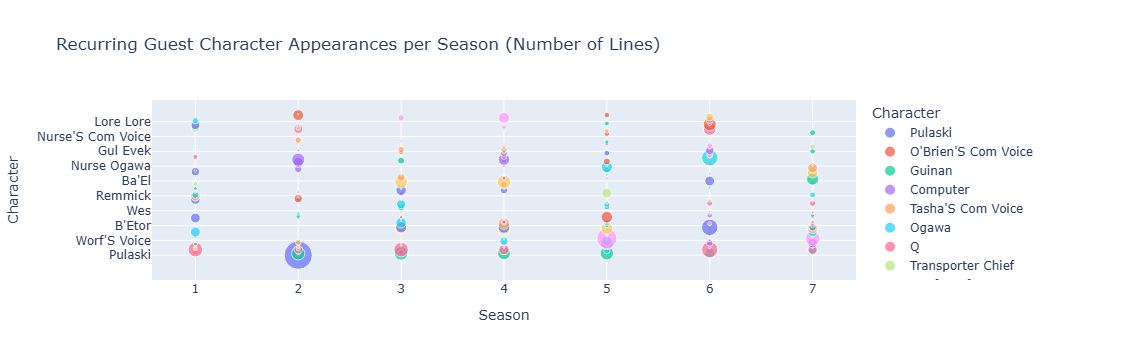

In [56]:
import pandas as pd
import plotly.express as px
import re

# Clean and normalize names
df_speech = df.dropna(subset=['who']).copy()

def clean_name(name):
    if not isinstance(name, str):
        return name
    name = name.strip()
    name = name.replace('"', '')
    name = re.sub(r'\s*\(.*?\)', '', name)
    name = name.title()
    alias_map = {
        "Q'": "Q",
        "Beverly": "Beverly Crusher",
        "Dr Crusher": "Beverly Crusher",
        "Deanna": "Deanna Troi",
        "Jean Luc": "Jean-Luc Picard",
    }
    if "'S Voice" in name.upper():
        name = name.split("'")[0].title()
    return alias_map.get(name, name)

df_speech['who'] = df_speech['who'].apply(clean_name)

# Remove main crew entirely
main_names = [
    'Picard', 'Riker', 'Crusher', 'Troi', 'La Forge', 'Data', 
    'Geordi', 'Deanna', 'Beverly', 'Will', 'Jean Luc'
]
pattern = '|'.join(main_names)
df_speech = df_speech[~df_speech['who'].str.contains(pattern, case=False, regex=True)]

# Total number of episodes
total_episodes = df_speech['Episode'].nunique()

# Count total appearances per character (by episode)
appearance_counts = df_speech.groupby('who')['Episode'].nunique()

# Select recurring guest characters (>1 appearance, <80% episodes)
recurring_guests = appearance_counts[(appearance_counts > 1) & 
                                     (appearance_counts < 0.8 * total_episodes)].index

# Filter the dataframe
guest_lines = df_speech[df_speech['who'].isin(recurring_guests)].copy()

# Count actual number of lines per season for each character
appearances = guest_lines.groupby(['Season', 'who']).size().reset_index(name='num_lines')

# Sort characters by total appearances descending
char_order = appearance_counts[recurring_guests].sort_values(ascending=False).index.tolist()

# Scatter plot with hover showing number of lines
fig = px.scatter(
    appearances,
    x='Season',
    y='who',
    size='num_lines',           # actual number of lines
    hover_data=['num_lines'],
    color='who',
    category_orders={'who': char_order},
    size_max=20,
    title='Recurring Guest Character Appearances per Season (Number of Lines)',
    labels={'who': 'Character', 'Season': 'Season', 'num_lines': 'Number of Lines'}
)

fig.update_layout(yaxis={'categoryorder':'array', 'categoryarray': char_order})
fig.show()


# Visualization 3
This is an interactive scatter plot of recurring guest characters with the sizes being the number of lines they have. The parameters are that they have to be in more than one and less than 80% of the episodes. It gives us an insight into the most popular guest spots and how often they were working into story lines. For example, my favorite character, Q, appears in every season but one (as well as making appearnces in other series).